In [80]:
import pandas as pd
import numpy as np
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

#### import data

In [5]:
df = pd.read_csv('application_train.csv')

#### Explore data

In [6]:
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
# The number of customers who apply for loans
nol = df.groupby('TARGET')['CODE_GENDER'].count().reset_index()
nol.rename(columns = {'CODE_GENDER' : 'Customers'}, inplace=True)

nol['Customers_pct'] = round(nol.Customers / nol.Customers.sum(), 2)
nol

,TARGET,Customers,Customers_pct
0,0,282686,0.92
1,1,24825,0.08


From the table above, we can see 92% did not had any problems in repaying the loan in given time and 8% was have problems, so let's dig deeper into the criteria for whether the customer not had any problems in repaying the loan.

In [9]:
# Marital status
df.NAME_FAMILY_STATUS.value_counts()

Married                 196432
Single / not married     45444
Civil marriage           29775
Separated                19770
Widow                    16088
Unknown                      2
Name: NAME_FAMILY_STATUS, dtype: int64

From table above, there are 6 category about marital, let's simplify it into 2 categories, namely married and unmarried

married = people who have a partner

unmarried = people who not have a partner or have had a partner

In [12]:
marital_status = []
married = ['Married', 'Civil marriage']

for i in df.NAME_FAMILY_STATUS:
    if i in married:
        marital_status.append('Married')
    else:
        marital_status.append('Unmarried')

df['marital_status'] = marital_status
df.drop(columns= 'NAME_FAMILY_STATUS', inplace=True)

In [16]:
ms_acc = df[df['TARGET'] == 0].groupby('marital_status')['CODE_GENDER'].count().reset_index()
ms_acc.rename({'CODE_GENDER': 'Customers'}, inplace=True)

ms_acc['Customers_pct'] = round(nol.Customers / nol.Customers.sum(), 2)
ms_acc

,marital_status,CODE_GENDER,Customers_pct
0,Married,208396,0.92
1,Unmarried,74290,0.08


74% from customer that dont have any problems to pay the loan is married.

In [19]:
ms = df[df['marital_status'] == 'Unmarried'].groupby(['TARGET', 'marital_status'])['CODE_GENDER'].count().reset_index()
ms.rename(columns = {'CODE_GENDER' : 'Customers'}, inplace=True)

ms['Customers_pct'] = round(ms.Customers / ms.Customers.sum(), 2)
ms

,TARGET,marital_status,Customers,Customers_pct
0,0,Unmarried,74290,0.91
1,1,Unmarried,7014,0.09


In [21]:
ms1= df[df['marital_status'] == 'Married'].groupby(['TARGET', 'marital_status'])['CODE_GENDER'].count().reset_index()
ms1.rename(columns = {'CODE_GENDER' : 'Customers'}, inplace=True)

ms1['Customers_pct'] = round(ms1.Customers / ms1.Customers.sum(), 2)
ms1

,TARGET,marital_status,Customers,Customers_pct
0,0,Married,208396,0.92
1,1,Married,17811,0.08


It's nothing special at marital status, because the number of loan applications received between the two categories has a value that is not much different

In [26]:
# Contract Type
ct = df.groupby(['TARGET', 'NAME_CONTRACT_TYPE'])['CODE_GENDER'].count().reset_index().sort_values(by='NAME_CONTRACT_TYPE')
ct.rename(columns = {'CODE_GENDER' : 'Customers'}, inplace=True)

name_ct = list(ct['NAME_CONTRACT_TYPE'].unique())
pct = []

for i in name_ct:
    data = ct[ct['NAME_CONTRACT_TYPE'] == i]
    total = data['Customers'].sum()
    for x, y in enumerate(data['Customers']):
        percentage = round(y / total, 2)
        pct.append(percentage)

ct['percent'] = pct
ct

,TARGET,NAME_CONTRACT_TYPE,Customers,percent
0,0,Cash loans,255011,0.92
2,1,Cash loans,23221,0.08
1,0,Revolving loans,27675,0.95
3,1,Revolving loans,1604,0.05


is nothing special in Contract_type, Percentage of customer have problems to pay the loans is similar. but cash loans is customer favorite.

#### EDA

In [27]:
# Occupation type
ot = df.groupby(['TARGET', 'OCCUPATION_TYPE'])['CODE_GENDER'].count().reset_index().sort_values(by=['OCCUPATION_TYPE', 'TARGET'])
ot.rename(columns = {'CODE_GENDER' : 'Customers'}, inplace=True)

name_ot = list(ot['OCCUPATION_TYPE'].unique())
percentage = []

for i in name_ot:
    data = ot[ot['OCCUPATION_TYPE'] == i]
    total = data['Customers'].sum()
    for x,y in enumerate(data['Customers']):
        pct = round(y / total, 2)
        percentage.append(pct)

ot['percentage'] = percentage
ot

,TARGET,OCCUPATION_TYPE,Customers,percentage
0,0,Accountants,9339,0.95
18,1,Accountants,474,0.05
1,0,Cleaning staff,4206,0.90
19,1,Cleaning staff,447,0.10
2,0,Cooking staff,5325,0.90
20,1,Cooking staff,621,0.10
3,0,Core staff,25832,0.94
21,1,Core staff,1738,0.06
4,0,Drivers,16496,0.89
22,1,Drivers,2107,0.11


From the table above, we can see HR staff, IT staff and Realty agents have a high percentage of accepted loan applications (92% - 94%) but the number of customers with these jobs who apply for loans is less than a thousand customers, so it is recommended that we create campaigns for these three jobs

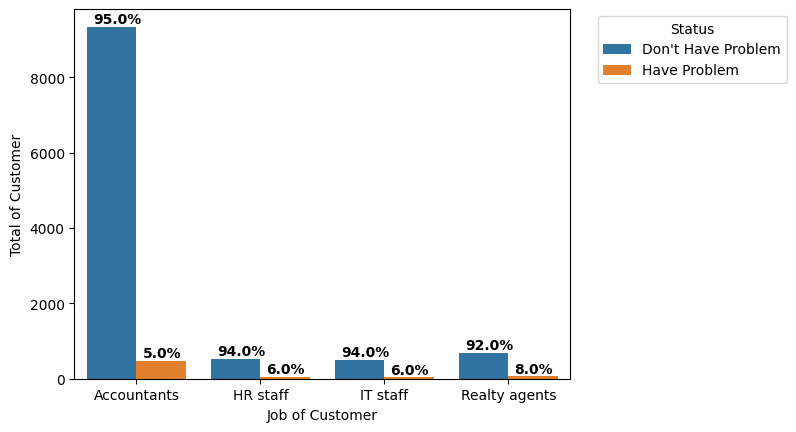

In [30]:
ot_2 = ot[ot['OCCUPATION_TYPE'].isin(['HR staff', 'IT staff', 'Realty agents', 'Accountants'])]
ot_2 = ot_2.reset_index()

mapping_target = {
    0: 'Don\'t'' Have Problem',
    1: 'Have Problem'
}

ot_2['TARGET'] = ot_2['TARGET'].map(mapping_target)

ax = sns.barplot(data = ot_2, x = 'OCCUPATION_TYPE', y = 'Customers', hue = 'TARGET')
plt.xlabel('Job of Customer')
plt.ylabel('Total of Customer')
plt.legend(title = 'Status', bbox_to_anchor=(1.45, 1))

for i, j in enumerate(ot_2['Customers']):
    if i%2 == 0:
        plt.text(i/2 - 0.35, j + 100, s=str(ot_2['percentage'][i] * 100) + '%', color='black', fontweight='bold')
    else:
        plt.text(i/2 - 0.45, j + 100, s= str(ot_2['percentage'][i] * 100) + '%', color='black', fontweight='bold')

plt.show()

In [31]:
# Age of the customer
# Since there is no customer age column,
# we will create it using the DAYS_BIRTH column which contains data on the difference between today and the customer's birthday.

df['age'] = np.floor(df['DAYS_BIRTH'] / -365).astype(int)
df.drop(columns= 'DAYS_BIRTH', inplace=True)

now we make a grup based on customer age following this rules :

Young Adult = 20 - 35

Adult = 35 - 50

Older > 50

In [32]:
age_cat = []
for i in df['age']:
    if i < 36:
        age_cat.append('Young Adult')
    elif i < 51:
        age_cat.append('Adult')
    else:
        age_cat.append('Older')

df['age_category'] = age_cat

In [39]:
g_age = df.groupby(['TARGET', 'age_category'])['CODE_GENDER'].count().reset_index().sort_values('age_category').reset_index()
g_age.rename(columns = {'CODE_GENDER' : 'Customers'}, inplace=True)
g_age.drop(columns='index', inplace=True)

name_ag = list(g_age['age_category'].unique())
percentage = []

for j in name_ag:
    data = g_age[g_age['age_category'] == j]
    total = data['Customers'].sum()
    for x, y in enumerate(data['Customers']):
        pct = round(y / total, 2)
        percentage.append(pct)

g_age['percentage'] = percentage

mapping_target = {
    0: 'Don\'t'' Have Problem',
    1: 'Have Problem'
}

g_age['TARGET'] = g_age['TARGET'].map(mapping_target)
g_age

,TARGET,age_category,Customers,percentage
0,Don't Have Problem,Adult,108678,0.92
1,Have Problem,Adult,9403,0.08
2,Don't Have Problem,Older,91718,0.94
3,Have Problem,Older,5469,0.06
4,Don't Have Problem,Young Adult,82290,0.89
5,Have Problem,Young Adult,9953,0.11


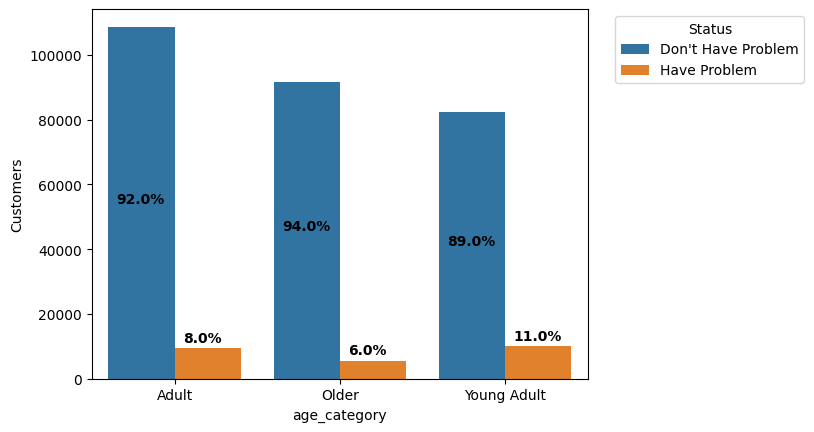

In [41]:
ax = sns.barplot(x = 'age_category', y= 'Customers', hue= g_age.TARGET, data = g_age)
plt.legend(title = 'Status', bbox_to_anchor = (1.45,1))

for i, v in enumerate(g_age['Customers']):
    if i%2 == 0:
        plt.text(i/2 - 0.35, v/2, s= str(g_age['percentage'][i]* 100) + '%', color='black', fontweight='bold')
    else:
        plt.text(i/2 - 0.45, v + 2000, s= str(g_age['percentage'][i] * 100) + '%', color='black', fontweight='bold')

plt.show(ax)

From graphic above, we can see that Adult (35-50 years old) is the age category that has the largest loan applications with 92% of the loans being paid off without experiencing any problems, so we can target adults to have a loan in Home credit Indonesia.

In [43]:
df.drop(columns = 'age_category', inplace=True)

In [44]:
# Income Type of consumer
itc = df.groupby(['TARGET', 'NAME_INCOME_TYPE', 'NAME_CONTRACT_TYPE'])['CODE_GENDER'].count().reset_index().sort_values(['NAME_INCOME_TYPE', 'NAME_CONTRACT_TYPE']).reset_index()
itc.rename(columns = {'CODE_GENDER' : 'Customers'}, inplace=True)
itc.drop(columns = 'index', inplace=True)

income_type   = list(itc['NAME_INCOME_TYPE'].unique())
percentage  = []

for i in income_type:
    data = itc[itc.NAME_INCOME_TYPE == i]
    contract_type = list(data['NAME_CONTRACT_TYPE'].unique())
    for x in contract_type:
        data2 = data[data.NAME_CONTRACT_TYPE == x]
        total = data2['Customers'].sum()
        for y,z in enumerate(data2['Customers']):
            pct = round(z / total, 2)
            percentage.append(pct)
            
itc['percentage'] = percentage
itc

,TARGET,NAME_INCOME_TYPE,NAME_CONTRACT_TYPE,Customers,percentage
0,0,Businessman,Revolving loans,10,1.00
1,0,Commercial associate,Cash loans,58662,0.92
2,1,Commercial associate,Cash loans,4990,0.08
3,0,Commercial associate,Revolving loans,7595,0.95
4,1,Commercial associate,Revolving loans,370,0.05
5,1,Maternity leave,Cash loans,2,1.00
6,0,Maternity leave,Revolving loans,3,1.00
7,0,Pensioner,Cash loans,49151,0.95
8,1,Pensioner,Cash loans,2842,0.05
9,0,Pensioner,Revolving loans,3229,0.96


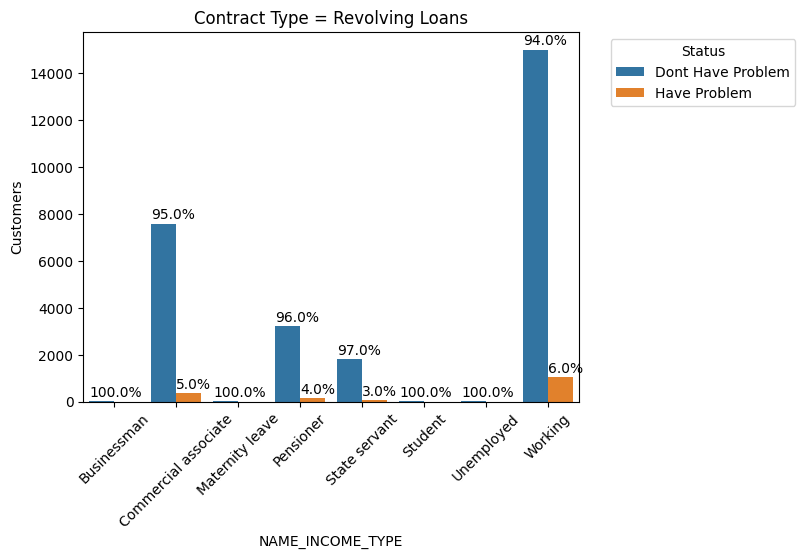

In [45]:
itc_rl = itc[itc['NAME_CONTRACT_TYPE'] == 'Revolving loans'].reset_index()

mapping_target = {
    1 : 'Have Problem',
    0 : 'Dont Have Problem'
}

itc_rl['TARGET'] = itc_rl['TARGET'].map(mapping_target)

ax = sns.barplot(x = 'NAME_INCOME_TYPE', y= 'Customers', data = itc_rl, hue = 'TARGET')
plt.title('Contract Type = Revolving Loans')
plt.xticks(rotation=45)
plt.legend(title = 'Status', bbox_to_anchor = (1.45,1))

#for i, v in enumerate(itc_rl['Customers']):
#   plt.text(i/2 - 0.2, v + 200, s= str(itc_rl['percentage'][i]* 100) + '%', color='black', fontweight='bold', fontsize = 8)
i = 0
itc_p = itc_rl.sort_values('TARGET').reset_index()
for p in ax.patches:
    widht, height = p.get_x(), p.get_height()
    if np.isnan(height) == True:
        continue
    else:
        plt.text(widht, height + 200, s = str(itc_p['percentage'][i]* 100) + '%' )
        i = i +1
        
plt.show()

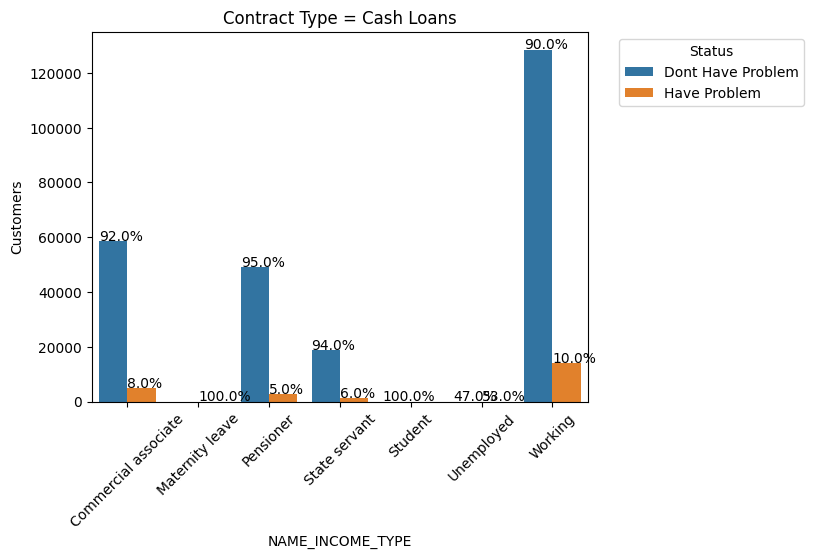

In [46]:
itc_cl = itc[itc['NAME_CONTRACT_TYPE'] == 'Cash loans'].reset_index()

mapping_target = {
    1 : 'Have Problem',
    0 : 'Dont Have Problem'
}

itc_cl['TARGET'] = itc_cl['TARGET'].map(mapping_target)

ax = sns.barplot(x = 'NAME_INCOME_TYPE', y= 'Customers', data = itc_cl, hue = 'TARGET')
plt.title('Contract Type = Cash Loans')
plt.xticks(rotation=45)
plt.legend(title = 'Status', bbox_to_anchor = (1.45,1))

#for i, v in enumerate(itc_rl['Customers']):
#   plt.text(i/2 - 0.2, v + 200, s= str(itc_rl['percentage'][i]* 100) + '%', color='black', fontweight='bold', fontsize = 8)
i = 0
itc_p2 = itc_cl.sort_values('TARGET').reset_index()
for p in ax.patches:
    widht, height = p.get_x(), p.get_height()
    if np.isnan(height) == True:
        continue
    else:
        plt.text(widht, height + 200, s = str(itc_p2['percentage'][i]* 100) + '%' )
        i = i +1
        
plt.show()

In [47]:
itc_cl

,index,TARGET,NAME_INCOME_TYPE,NAME_CONTRACT_TYPE,Customers,percentage
0,1,Dont Have Problem,Commercial associate,Cash loans,58662,0.92
1,2,Have Problem,Commercial associate,Cash loans,4990,0.08
2,5,Have Problem,Maternity leave,Cash loans,2,1.00
3,7,Dont Have Problem,Pensioner,Cash loans,49151,0.95
4,8,Have Problem,Pensioner,Cash loans,2842,0.05
5,11,Dont Have Problem,State servant,Cash loans,18648,0.94
6,12,Have Problem,State servant,Cash loans,1188,0.06
7,15,Dont Have Problem,Student,Cash loans,15,1.00
8,17,Dont Have Problem,Unemployed,Cash loans,7,0.47
9,18,Have Problem,Unemployed,Cash loans,8,0.53


#### Data Cleaning

In [48]:
df.duplicated().sum()

0

In [49]:
count_nv = pd.DataFrame(df.isnull().sum(), columns=['Total Null Data']).reset_index()
count_nv['Percentage'] = (count_nv['Total Null Data'] / len(df)) * 100
count_nv[count_nv['Percentage'] > 40].sort_values(by='Percentage', ascending=False)

,index,Total Null Data,Percentage
46,COMMONAREA_AVG,214865,69.872297
74,COMMONAREA_MEDI,214865,69.872297
60,COMMONAREA_MODE,214865,69.872297
82,NONLIVINGAPARTMENTS_MEDI,213514,69.432963
68,NONLIVINGAPARTMENTS_MODE,213514,69.432963
54,NONLIVINGAPARTMENTS_AVG,213514,69.432963
84,FONDKAPREMONT_MODE,210295,68.386172
80,LIVINGAPARTMENTS_MEDI,210199,68.354953
52,LIVINGAPARTMENTS_AVG,210199,68.354953
66,LIVINGAPARTMENTS_MODE,210199,68.354953


we will remove the feature that have more than 40% null data

In [50]:
data = list(count_nv[count_nv['Percentage'] > 40]['index'])
df = df.drop(columns = data)
df = df.drop(columns = 'SK_ID_CURR')

In [51]:
count_nv = pd.DataFrame(df.isnull().sum(), columns=['Total Null Data']).reset_index()
count_nv['Percentage'] = (count_nv['Total Null Data'] / len(df)) * 100
still_null = count_nv[count_nv['Percentage'] != 0].sort_values(by='Percentage', ascending=False)

In [52]:
a = list(still_null['index'])
df[a].dtypes

for i in a:
    data = df[i]
    types = str(data.dtype)
    if types == 'object':
        df[i].fillna(df[i].mode()[0], inplace=True)
    else:
        df[i].fillna(df[i].median(), inplace=True)

In [53]:
count_nv = pd.DataFrame(df.isnull().sum(), columns=['Total Null Data']).reset_index()
count_nv['Percentage'] = ( count_nv['Total Null Data'] / len(df) ) * 100
count_nv[count_nv['Percentage'] > 0].sort_values(by='Percentage', ascending=False)

,index,Total Null Data,Percentage


In [54]:
# Replace unknown value
df['CODE_GENDER'] = df['CODE_GENDER'].replace(['XNA'], df['CODE_GENDER'].mode()[0])
df['ORGANIZATION_TYPE'] = df['ORGANIZATION_TYPE'].replace(['XNA'], df['ORGANIZATION_TYPE'].mode()[0])

In [55]:
# Remove flag document column
FLAG_DOCUMENT = [col for col in df.columns if 'FLAG_DOCUMENT' in col]
df.drop(columns = FLAG_DOCUMENT, axis=1, inplace=True)

#### Feature Engineering

In [56]:
x = df.drop(columns = 'TARGET')

In [58]:
# Numeric data type
num = x.select_dtypes(exclude='object')

In [59]:
num.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,...,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,age
0,0,202500.0,406597.5,24700.5,351000.0,0.018801,-637,-3648.0,-2120,1,...,2.0,2.0,-1134.0,0.0,0.0,0.0,0.0,0.0,1.0,25
1,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-1188,-1186.0,-291,1,...,1.0,0.0,-828.0,0.0,0.0,0.0,0.0,0.0,0.0,45
2,0,67500.0,135000.0,6750.0,135000.0,0.010032,-225,-4260.0,-2531,1,...,0.0,0.0,-815.0,0.0,0.0,0.0,0.0,0.0,0.0,52
3,0,135000.0,312682.5,29686.5,297000.0,0.008019,-3039,-9833.0,-2437,1,...,2.0,0.0,-617.0,0.0,0.0,0.0,0.0,0.0,1.0,52
4,0,121500.0,513000.0,21865.5,513000.0,0.028663,-3038,-4311.0,-3458,1,...,0.0,0.0,-1106.0,0.0,0.0,0.0,0.0,0.0,0.0,54


In [60]:
# Change the negative value on column to positive value
negative_column = num.columns[(num < 0).any()].tolist()
num[negative_column] = num[negative_column] * -1
num.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,...,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,age
0,0,202500.0,406597.5,24700.5,351000.0,0.018801,637,3648.0,2120,1,...,2.0,2.0,1134.0,0.0,0.0,0.0,0.0,0.0,1.0,25
1,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,1188,1186.0,291,1,...,1.0,0.0,828.0,0.0,0.0,0.0,0.0,0.0,0.0,45
2,0,67500.0,135000.0,6750.0,135000.0,0.010032,225,4260.0,2531,1,...,0.0,0.0,815.0,0.0,0.0,0.0,0.0,0.0,0.0,52
3,0,135000.0,312682.5,29686.5,297000.0,0.008019,3039,9833.0,2437,1,...,2.0,0.0,617.0,0.0,0.0,0.0,0.0,0.0,1.0,52
4,0,121500.0,513000.0,21865.5,513000.0,0.028663,3038,4311.0,3458,1,...,0.0,0.0,1106.0,0.0,0.0,0.0,0.0,0.0,0.0,54


In [63]:
# Look for a numeric data type that has a unique value > 2
df_num = pd.DataFrame(num.nunique(), columns=['Total_unique']).reset_index()
df_num = df_num.rename(columns={'index': 'Name_of_column'})

num_a = []
num_b = []

for i, y in enumerate(df_num.Name_of_column):
    if df_num['Total_unique'][i] > 2:
        num_a.append(y)
    else:
        num_b.append(y)

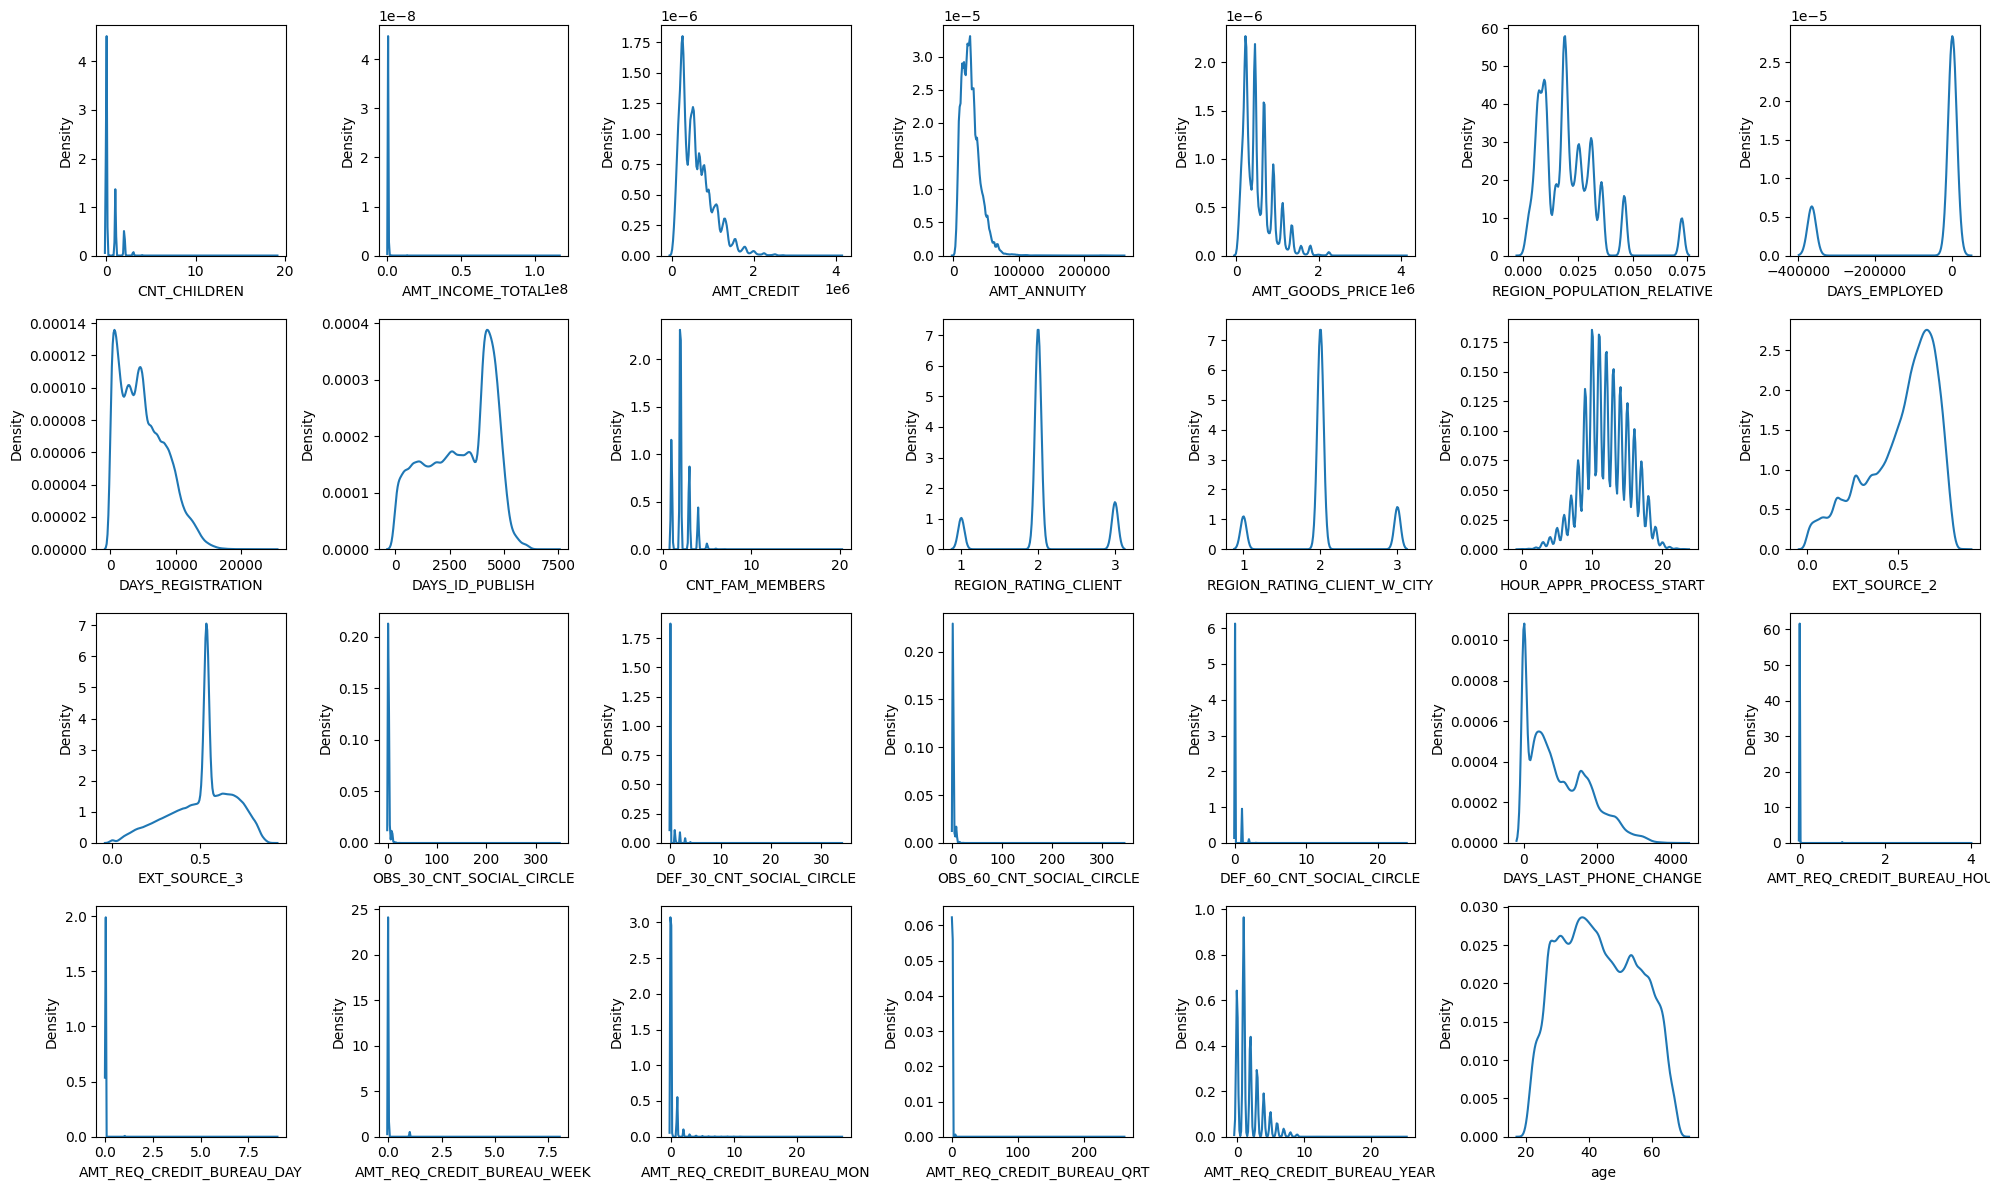

In [64]:
# Look distribution data
plt.figure(figsize=(20,12))

for i, column in enumerate(num[num_a].columns, 1):
    plt.subplot(4, 7, i)
    sns.kdeplot(data=num[num_a], x=num[column])
    plt.tight_layout()

the data distribution is not close to the normal distribution, so it needs to be normalized

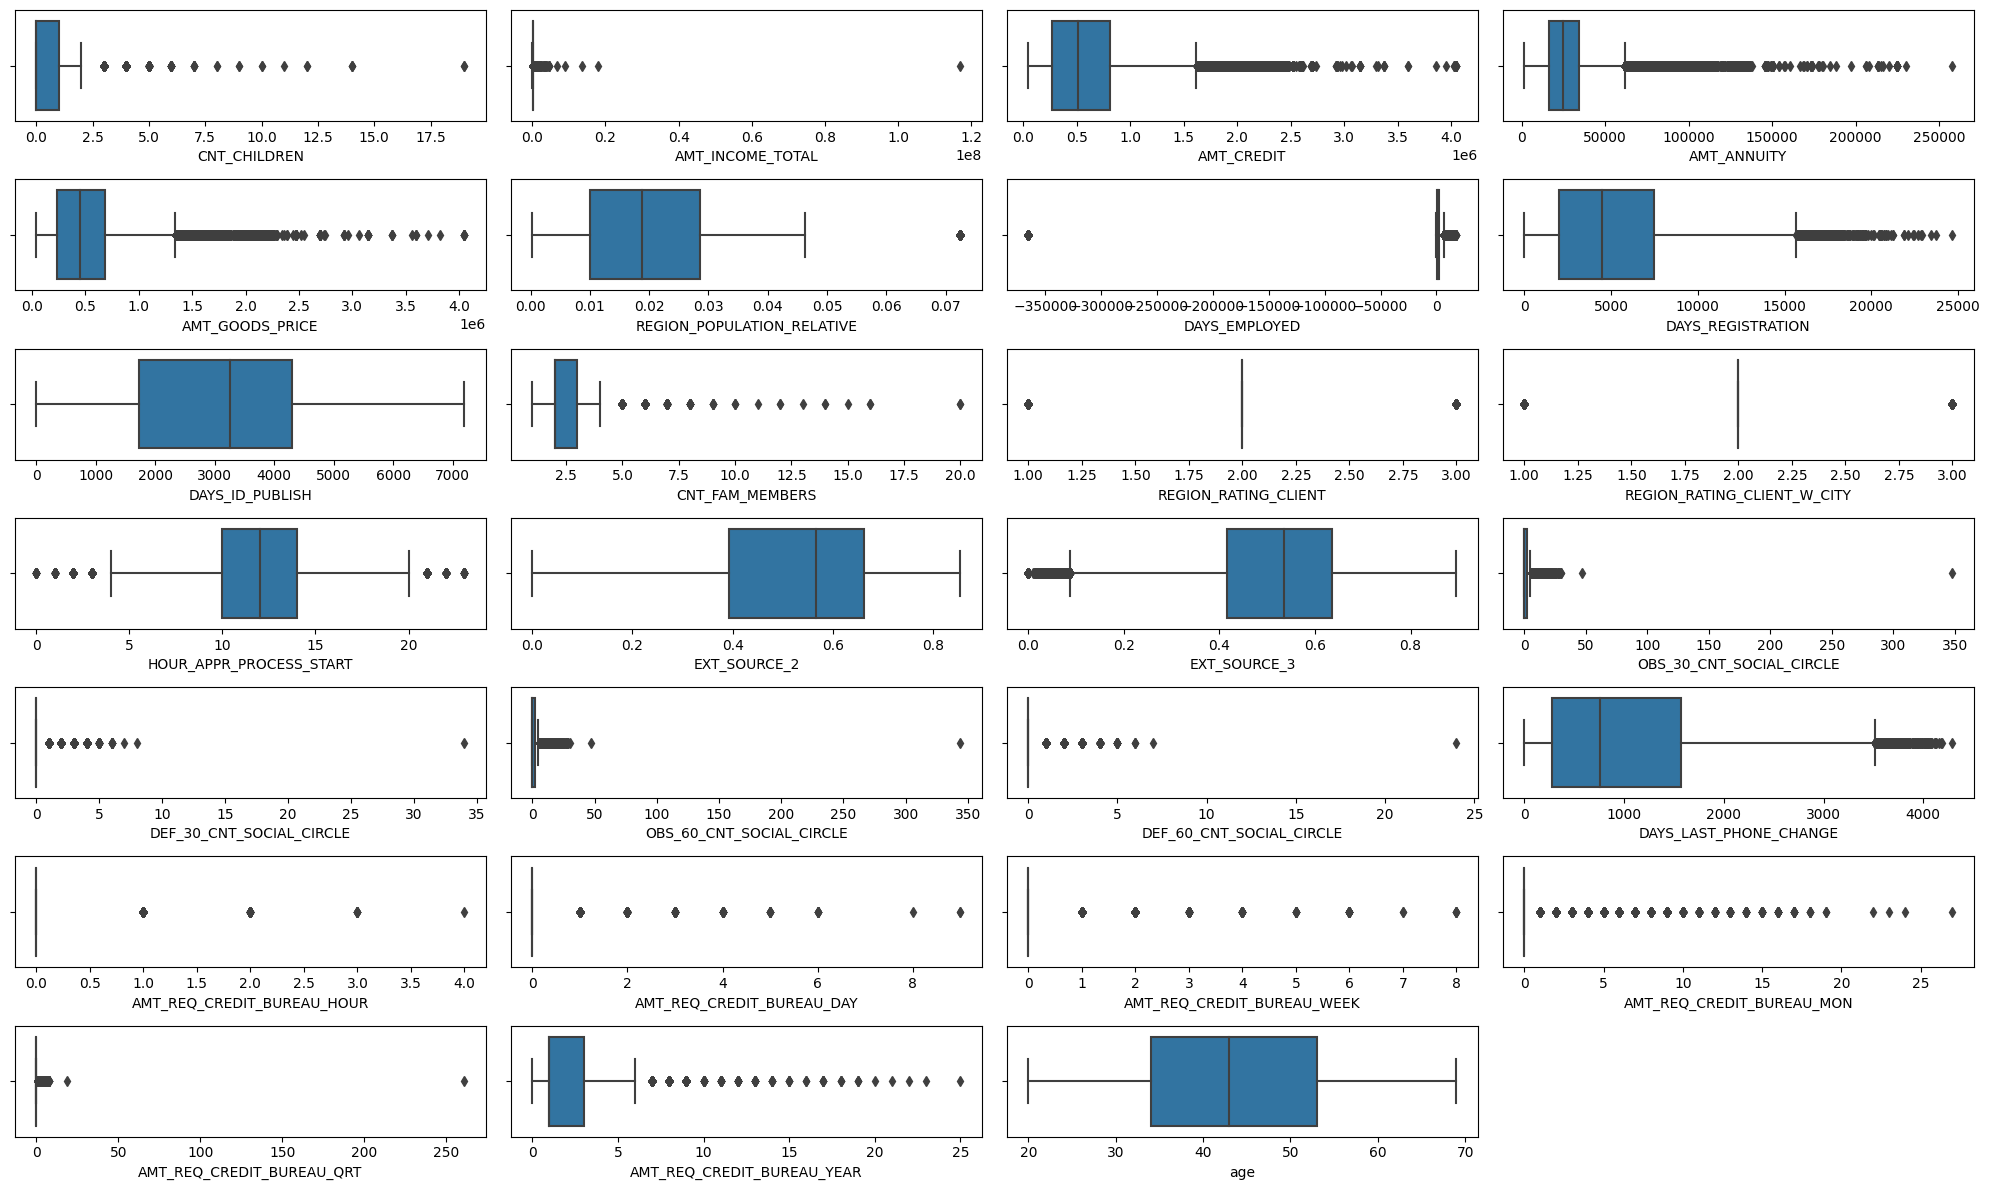

In [65]:
plt.figure(figsize=(20,12))

for i, column in enumerate (num[num_a].columns, 1):
    plt.subplot(7,4,i)
    sns.boxplot(data=num[num_a], x=num[column])
    plt.tight_layout()

the abnormal column is the cnt_children column, so we need to remove the outlier in that column

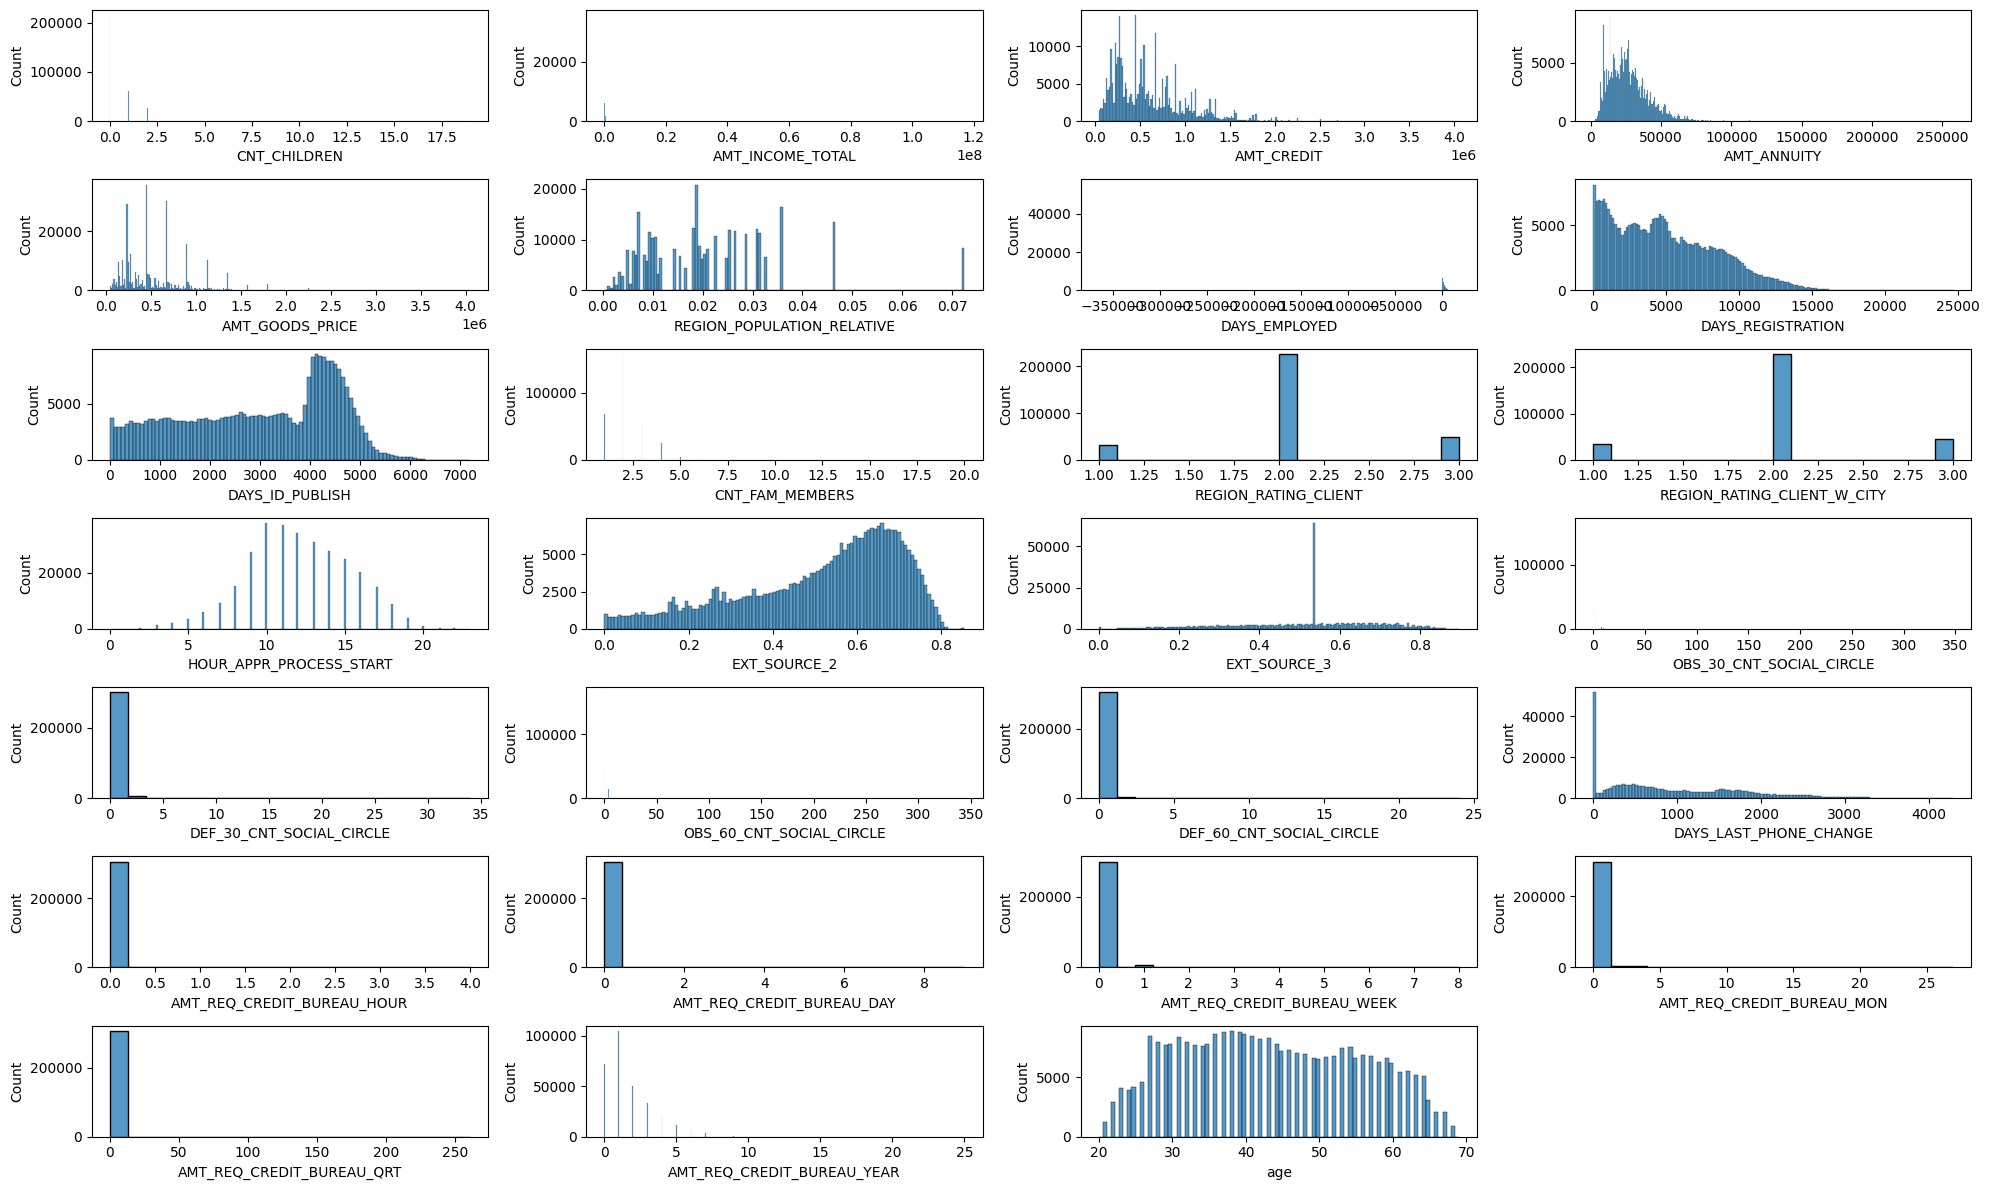

In [67]:
plt.figure(figsize=(20,12))

for i, column in enumerate (num[num_a].columns, 1):
    plt.subplot(7,4,i)
    sns.histplot(data=num[num_a], x=num[column])
    plt.tight_layout()

In [68]:
# remove outlier
print(f'Row before delete outlier at CNT_children :  {len(df)}')

filtered_entries = np.array([True] * len(df))

zscore = abs(stats.zscore(df['CNT_CHILDREN'])) # hitung absolute z-scorenya
filtered_entries = (zscore < 3) & filtered_entries # keep yang kurang dari 3 absolute z-scorenya
    
df = df[filtered_entries] # filter, cuma ambil yang z-scorenya dibawah 3

print(f'Row after delete outlier at CNT_children : {len(df)}')

Row before delete outlier at CNT_children :  307511
Row after delete outlier at CNT_children : 303239


In [69]:
# feature transformation
x = df.drop(columns = 'TARGET', axis=1)
num = x[num_a]

In [70]:
num_mean = num.mean()
num_std = num.std()

num = (num - num_mean) / num_std
num.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,CNT_FAM_MEMBERS,...,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,age
0,-0.589198,0.141631,-0.477744,-0.165346,-0.506964,-0.150759,-0.459710,0.385831,0.577304,-1.320962,...,0.252564,5.254914,-0.206172,-0.07111,-0.058754,-0.155798,-0.270044,-0.307919,-0.441070,-1.544674
1,-0.589198,0.424753,1.725509,0.594213,1.600729,-1.253789,-0.463592,1.083617,1.789288,-0.131831,...,-0.168056,-0.275683,0.163731,-0.07111,-0.058754,-0.155798,-0.270044,-0.307919,-1.007106,0.122835
2,-0.589198,-0.424615,-1.152447,-1.405069,-1.091757,-0.784603,-0.456807,0.212377,0.304955,-1.320962,...,-0.588676,-0.275683,0.179446,-0.07111,-0.058754,-0.155798,-0.270044,-0.307919,-1.007106,0.706463
3,-0.589198,-0.141492,-0.711048,0.179004,-0.653162,-0.930108,-0.476632,-1.367137,0.367244,-0.131831,...,0.252564,-0.275683,0.418795,-0.07111,-0.058754,-0.155798,-0.270044,-0.307919,-0.441070,0.706463
4,-0.589198,-0.198116,-0.213418,-0.361141,-0.068369,0.562091,-0.476625,0.197922,-0.309320,-1.320962,...,-0.588676,-0.275683,-0.172324,-0.07111,-0.058754,-0.155798,-0.270044,-0.307919,-1.007106,0.873213


In [71]:
num_1 = x[num_b]
num_1 = num_1.loc[~num_1.index.duplicated(keep='first')]

num = pd.concat([num, num_1], axis=1)
num

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,CNT_FAM_MEMBERS,...,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY
0,-0.589198,0.141631,-0.477744,-0.165346,-0.506964,-0.150759,-0.459710,0.385831,0.577304,-1.320962,...,0,1,1,0,0,0,0,0,0,0
1,-0.589198,0.424753,1.725509,0.594213,1.600729,-1.253789,-0.463592,1.083617,1.789288,-0.131831,...,0,1,1,0,0,0,0,0,0,0
2,-0.589198,-0.424615,-1.152447,-1.405069,-1.091757,-0.784603,-0.456807,0.212377,0.304955,-1.320962,...,1,1,1,0,0,0,0,0,0,0
3,-0.589198,-0.141492,-0.711048,0.179004,-0.653162,-0.930108,-0.476632,-1.367137,0.367244,-0.131831,...,0,1,0,0,0,0,0,0,0,0
4,-0.589198,-0.198116,-0.213418,-0.361141,-0.068369,0.562091,-0.476625,0.197922,-0.309320,-1.320962,...,0,1,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,-0.589198,-0.047118,-0.855088,0.032003,-0.848093,0.843848,-0.456884,-0.976864,0.668749,-1.320962,...,0,1,0,0,0,0,0,0,0,0
307507,-0.589198,-0.405740,-0.818198,-1.042382,-0.848093,0.309175,2.118014,0.176098,-0.728114,-1.320962,...,0,1,1,0,0,0,0,0,0,0
307508,-0.589198,-0.065993,0.195641,0.199205,0.126562,-1.148184,-0.511027,-0.489661,-1.430522,-1.320962,...,0,1,0,1,0,0,0,0,1,1
307509,-0.589198,0.009507,-0.568393,-0.475821,-0.592246,-1.125704,-0.488940,0.693628,1.365193,-0.131831,...,0,1,0,0,0,0,0,1,1,0


#### Object data type

In [72]:
# Feature Transformation
obj = x.select_dtypes(include='object')
df_obj = pd.DataFrame(obj.nunique(), columns=['Total_unique']).reset_index()
df_obj = df_obj.rename(columns={'index': 'Name_of_column'})

obj_a = []
obj_b = []
for i, k in enumerate(df_obj.Name_of_column):
    if df_obj['Total_unique'][i] > 2:
        obj_a.append(k)
    else:
        obj_b.append(k)
obj

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,marital_status
0,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3,Unmarried
1,Cash loans,F,N,N,Family,State servant,Higher education,House / apartment,Core staff,MONDAY,School,Married
2,Revolving loans,M,Y,Y,Unaccompanied,Working,Secondary / secondary special,House / apartment,Laborers,MONDAY,Government,Unmarried
3,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3,Married
4,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,House / apartment,Core staff,THURSDAY,Religion,Unmarried
...,...,...,...,...,...,...,...,...,...,...,...,...
307506,Cash loans,M,N,N,Unaccompanied,Working,Secondary / secondary special,With parents,Sales staff,THURSDAY,Services,Unmarried
307507,Cash loans,F,N,Y,Unaccompanied,Pensioner,Secondary / secondary special,House / apartment,Laborers,MONDAY,Business Entity Type 3,Unmarried
307508,Cash loans,F,N,Y,Unaccompanied,Working,Higher education,House / apartment,Managers,THURSDAY,School,Unmarried
307509,Cash loans,F,N,Y,Unaccompanied,Commercial associate,Secondary / secondary special,House / apartment,Laborers,WEDNESDAY,Business Entity Type 1,Married


In [74]:
# one hot encoding
for cat in obj_a:
    onehot = pd.get_dummies(obj[cat], prefix=cat)
    obj = obj.join(onehot)
obj = obj.drop(columns=obj_a)

In [76]:
# label encoding
label_encoder = preprocessing.LabelEncoder()

for cat in obj_b:
    obj[cat] = label_encoder.fit_transform(obj[cat])
obj

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,marital_status,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,...,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University
0,0,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
307507,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
307508,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
307509,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [77]:
df_train = pd.concat([num, obj], axis=1)

In [78]:
df = pd.concat([df_train, df['TARGET']], axis=1)

In [79]:
# Data splitting
x = df.drop(columns = 'TARGET')
y = df['TARGET']

In [81]:
# oversampling
sm = SMOTE(random_state = 2)
x_over, y_over = sm.fit_resample(x, y.ravel())

In [82]:
x_train, x_test, y_train, y_test = train_test_split(x_over, y_over, test_size=0.3, random_state=42)

In [83]:
# Undersampling
rus = RandomUnderSampler(random_state=42)
x_under, y_under = rus.fit_resample(x, y.ravel())

In [84]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(x_under, y_under, test_size=0.3, random_state=42)

#### Train Logistic Regression Model

In [86]:
# with oversampling data
def confusionmatrix(predictions, y_test):
    cm = confusion_matrix(y_test, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    return disp.plot()

c:\Users\panji\ansel\python dan vscode\Lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.89      0.99      0.94     83391
           1       0.99      0.88      0.93     83915

    accuracy                           0.94    167306
   macro avg       0.94      0.94      0.94    167306
weighted avg       0.94      0.94      0.94    167306



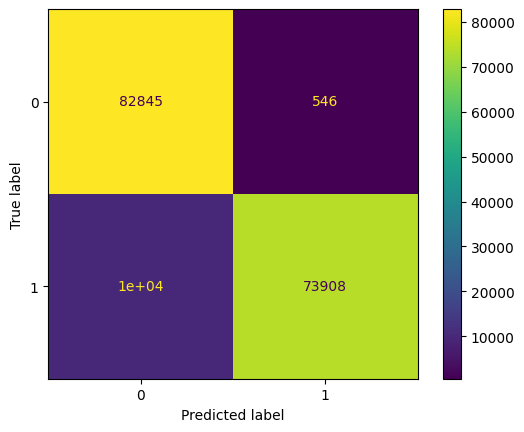

In [88]:
lr1 = LogisticRegression()
lr1.fit(x_train, y_train.ravel())
predictions = lr1.predict(x_test)

# print classification report
print(classification_report(y_test, predictions))
confusionmatrix(predictions, y_test)

              precision    recall  f1-score   support

           0       0.89      0.99      0.94    195452
           1       0.99      0.88      0.93    194928

    accuracy                           0.94    390380
   macro avg       0.94      0.94      0.94    390380
weighted avg       0.94      0.94      0.94    390380



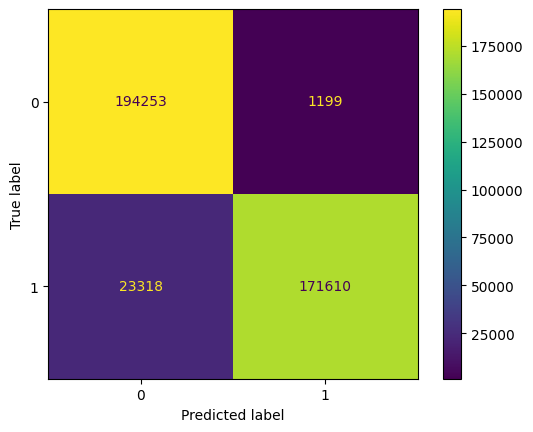

In [89]:
predictions = lr1.predict(x_train)

# print classification report
print(classification_report(y_train, predictions))
confusionmatrix(predictions, y_train)

              precision    recall  f1-score   support

           0       0.67      0.69      0.68      7289
           1       0.68      0.66      0.67      7349

    accuracy                           0.68     14638
   macro avg       0.68      0.68      0.68     14638
weighted avg       0.68      0.68      0.68     14638



c:\Users\panji\ansel\python dan vscode\Lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


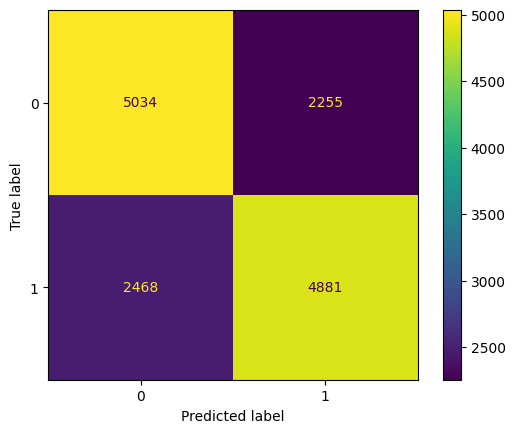

In [90]:
# with undersampling
lr2 = LogisticRegression()
lr2.fit(x_train2, y_train2)
predictions2 = lr2.predict(x_test2)

# print classification report
print(classification_report(y_test2, predictions2))
confusionmatrix(predictions2, y_test2)

              precision    recall  f1-score   support

           0       0.68      0.69      0.68     17107
           1       0.68      0.67      0.68     17047

    accuracy                           0.68     34154
   macro avg       0.68      0.68      0.68     34154
weighted avg       0.68      0.68      0.68     34154



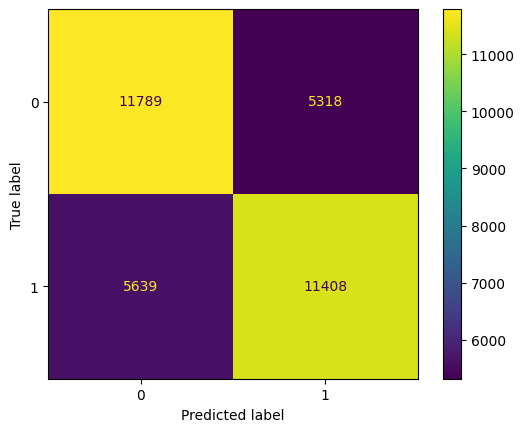

In [91]:
predictions = lr2.predict(x_train2)

# print classification report
print(classification_report(y_train2, predictions))
confusionmatrix(predictions, y_train2)

#### Train XGBoost Model

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     83391
           1       1.00      0.91      0.95     83915

    accuracy                           0.95    167306
   macro avg       0.96      0.95      0.95    167306
weighted avg       0.96      0.95      0.95    167306



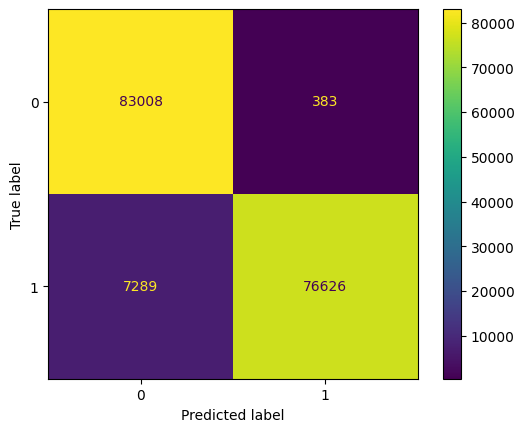

In [93]:
# with oversampling data
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
xgb_model.fit(x_train, y_train)

predictions = xgb_model.predict(x_test)

#print classification report
print(classification_report(y_test, predictions))
confusionmatrix(predictions, y_test)

              precision    recall  f1-score   support

           0       0.92      1.00      0.96    195452
           1       1.00      0.92      0.96    194928

    accuracy                           0.96    390380
   macro avg       0.96      0.96      0.96    390380
weighted avg       0.96      0.96      0.96    390380



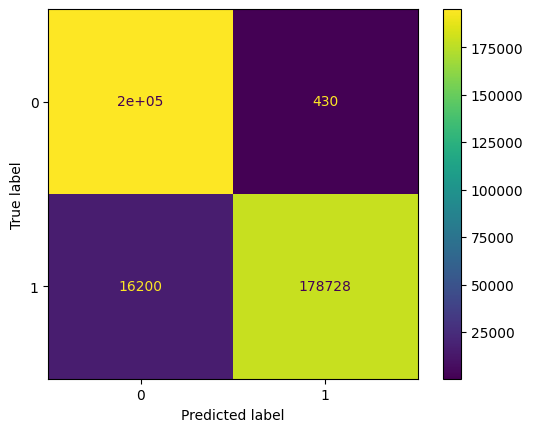

In [94]:
predictions = xgb_model.predict(x_train)

# print classification report
print(classification_report(y_train, predictions))
confusionmatrix(predictions, y_train)

#### Random forest

              precision    recall  f1-score   support

           0       0.92      0.99      0.96     83391
           1       0.99      0.92      0.95     83915

    accuracy                           0.96    167306
   macro avg       0.96      0.96      0.96    167306
weighted avg       0.96      0.96      0.96    167306



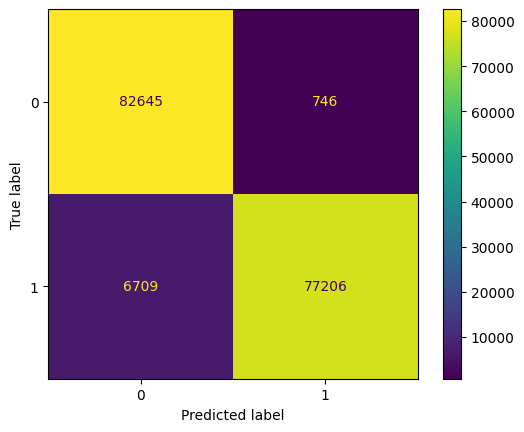

In [95]:
rf_model = RandomForestClassifier().fit(x_train, y_train)
predictions = rf_model.predict(x_test)

# print classification report
print(classification_report(y_test, predictions))
confusionmatrix(predictions, y_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    195452
           1       1.00      1.00      1.00    194928

    accuracy                           1.00    390380
   macro avg       1.00      1.00      1.00    390380
weighted avg       1.00      1.00      1.00    390380



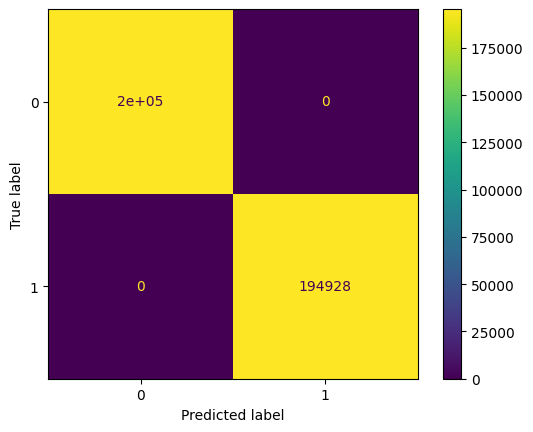

In [96]:
predictions = rf_model.predict(x_train)

# print classification report
print(classification_report(y_train, predictions))
confusionmatrix(predictions, y_train)

From 3 model, Random forest was the best because random forest have a higher accuracy, precision and recall than the others.

#### Predictions

In [118]:
df_test = pd.read_csv('application_test.csv')

In [119]:
df_test['CODE_GENDER'] = df_test['CODE_GENDER'].replace(['XNA'], df_test['CODE_GENDER'].mode()[0])
df_test['ORGANIZATION_TYPE'] = df_test['ORGANIZATION_TYPE'].replace(['XNA'], df_test['ORGANIZATION_TYPE'].mode()[0])

Marital_status = []
married = ['Married', 'Civil marriage']

for i in df_test.NAME_FAMILY_STATUS:
    if i in married:
        Marital_status.append('Married')
    else:
        Marital_status.append('Unmarried')

df_test['marital_status'] = Marital_status
df_test.drop(columns= 'NAME_FAMILY_STATUS', inplace=True)

df_test['age'] = np.floor(df_test['DAYS_BIRTH'] / -365).astype(int)
df_test.drop(columns= 'DAYS_BIRTH', inplace=True)

In [120]:
count_nv = pd.DataFrame(df_test.isnull().sum(), columns=['Total Null Data']).reset_index()
count_nv['Percentage'] = ( count_nv['Total Null Data'] / len(df) ) * 100
still_null = count_nv[count_nv['Percentage'] > 0].sort_values(by='Percentage', ascending=False)

In [121]:
a = list(still_null['index'])

for i in a:
    data = df_test[i]
    types = str(data.dtype)
    if types == 'object':
        df_test[i].fillna(df_test[i].mode()[0], inplace=True)
    else:
        df_test[i].fillna(df_test[i].median(), inplace=True)

In [122]:
num = df_test[num_a]

In [123]:
num = (num - num_mean) / num_std
num.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,CNT_FAM_MEMBERS,...,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,age
0,-0.589198,-0.141492,-0.074799,-0.451269,-0.238934,-0.147217,-0.471630,-0.045538,1.444048,-0.131831,...,-0.588676,-0.275683,-0.938725,-0.07111,-0.058754,-0.155798,-0.270044,-0.307919,-1.007106,0.706463
1,-0.589198,-0.292491,-0.934414,-0.671615,-0.969925,1.077392,-0.486707,-1.164490,0.906640,-0.131831,...,-0.588676,-0.275683,1.164645,-0.07111,-0.058754,-0.155798,-0.270044,-0.307919,0.691001,0.456336
2,-0.589198,0.141631,0.159868,2.947791,0.248394,-0.129074,-0.486630,0.803313,-0.339140,-0.131831,...,-0.588676,-0.275683,0.129884,-0.07111,-0.058754,-0.155798,-0.270044,1.032087,1.257036,0.873213
3,2.528453,0.613502,2.424807,1.514138,2.806865,0.397937,-0.468368,0.852911,-0.806307,2.246432,...,-0.588676,-0.275683,-1.017299,-0.07111,-0.058754,-0.155798,-0.270044,-0.307919,0.691001,-0.460793
4,0.969627,0.047256,0.066055,0.343410,0.236211,-0.784603,-0.470658,0.286066,-0.842090,1.057301,...,-0.588676,-0.275683,0.172193,-0.07111,-0.058754,-0.155798,-0.270044,-0.307919,0.124965,-0.710920


In [124]:
num_1 = df_test[num_b]
num_1 = num_1.loc[~num_1.index.duplicated(keep='first')]

num = pd.concat([num, num_1], axis=1)
num

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,CNT_FAM_MEMBERS,...,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY
0,-0.589198,-0.141492,-0.074799,-0.451269,-0.238934,-0.147217,-0.471630,-0.045538,1.444048,-0.131831,...,0,1,0,1,0,0,0,0,0,0
1,-0.589198,-0.292491,-0.934414,-0.671615,-0.969925,1.077392,-0.486707,-1.164490,0.906640,-0.131831,...,0,1,0,0,0,0,0,0,0,0
2,-0.589198,0.141631,0.159868,2.947791,0.248394,-0.129074,-0.486630,0.803313,-0.339140,-0.131831,...,0,1,0,0,0,0,0,0,0,0
3,2.528453,0.613502,2.424807,1.514138,2.806865,0.397937,-0.468368,0.852911,-0.806307,2.246432,...,0,1,1,0,0,0,0,0,0,0
4,0.969627,0.047256,0.066055,0.343410,0.236211,-0.784603,-0.470658,0.286066,-0.842090,1.057301,...,1,1,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,-0.589198,-0.198116,-0.462932,-0.664467,-0.726261,-1.362140,-0.491639,-1.157688,-0.270224,-1.320962,...,1,1,1,0,0,0,0,0,0,0
48740,2.528453,-0.047118,0.058386,0.332532,-0.117102,1.077392,-0.463317,0.565238,-0.007815,2.246432,...,0,1,0,0,0,0,0,0,1,1
48741,0.969627,0.141631,-0.705290,0.422038,-0.604429,0.397937,-0.476618,0.659901,0.985495,1.057301,...,0,1,1,0,0,0,0,0,0,0
48742,-0.589198,0.236005,-0.369923,-0.135821,-0.238934,-0.147217,-0.474462,1.005676,1.078266,-0.131831,...,1,1,1,0,0,1,1,0,1,1


In [125]:
obj = df_test.select_dtypes(include='object')

for cat in obj_a:
    onehots = pd.get_dummies(obj[cat], prefix=cat)
    obj = obj.join(onehots)
    
obj = obj.drop(columns = obj_a)

In [126]:
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()

# Encode labels in column 'species'.
for cat in obj_b:
    obj[cat]= label_encoder.fit_transform(obj[cat])

obj

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,marital_status,NAME_TYPE_SUITE_Children,...,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University
0,0,0,0,1,reg oper account,block of flats,"Stone, brick",No,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,1,reg oper account,block of flats,Panel,No,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,1,1,reg oper account,block of flats,Panel,No,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,1,reg oper account,block of flats,Panel,No,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,1,0,reg oper account,block of flats,Panel,No,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,0,0,0,1,reg oper account,block of flats,Panel,No,1,0,...,0,0,0,0,0,0,0,0,0,0
48740,0,0,0,0,reg oper account,block of flats,Panel,No,0,0,...,0,0,0,0,1,0,0,0,0,0
48741,0,0,1,1,reg oper account,block of flats,"Stone, brick",No,0,0,...,0,0,0,0,0,0,0,0,0,0
48742,0,1,0,0,reg oper account,block of flats,Panel,No,0,0,...,0,0,0,0,0,0,0,0,0,0


In [127]:
df_test = pd.concat([num, obj], axis=1)

In [128]:
train = set(df.columns)

In [129]:
train.remove('TARGET')

In [130]:
not_in_test = train - set(df_test.columns)
not_in_test = list(not_in_test)

In [131]:
df_test[not_in_test] = 0

In [132]:
column_train = list(df.columns)
column_train.remove('TARGET')
df_test = df_test[column_train]

In [133]:
predictions = rf_model.predict(df_test)

In [134]:
df_test['TARGET'] = predictions

In [135]:
df_test['TARGET'].value_counts()

0    48103
1      641
Name: TARGET, dtype: int64